### Relevante pakker

In [555]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

Merk: ChatGPT har blitt brukt for å få hjelp til å skrive deler av denne koden.

### Rense dataene

In [556]:
df = pd.read_csv("Data/lego.population.csv", sep = ",", encoding = "latin1")
df

,Item_Number,Set_Name,Theme,Pieces,Price,Amazon_Price,Year,Ages,Pages,Minifigures,Packaging,Weight,Unique_Pieces,Availability,Size
0,41916,Extra Dots - Series 2,DOTS,109.0,$3.99,$3.44,2020,Ages_6+,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
1,41908,Extra Dots - Series 1,DOTS,109.0,$3.99,$3.99,2020,Ages_6+,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
2,11006,Creative Blue Bricks,Classic,52.0,$4.99,$4.93,2020,Ages_4+,37.0,NaN,Box,NaN,28.0,Retail,Small
3,11007,Creative Green Bricks,Classic,60.0,$4.99,$4.93,2020,Ages_4+,37.0,NaN,Box,NaN,36.0,Retail,Small
4,41901,Funky Animals Bracelet,DOTS,33.0,$4.99,$4.99,2020,Ages_6+,NaN,NaN,Foil pack,NaN,10.0,Retail,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,45678,SPIKE Prime Set,LEGO® Education,528.0,$329.95,NaN,2020,Ages_10+,NaN,2.0,NaN,NaN,108.0,NaN,Small
1300,71367,Mario's House & Yoshi,LEGO® Super Mario,205.0,$29.99,NaN,2020,Ages_6+,NaN,2.0,Box,NaN,114.0,Retail,Small
1301,71368,Toad's Treasure Hunt,LEGO® Super Mario,464.0,$69.99,NaN,2020,Ages_8+,NaN,4.0,Box,NaN,195.0,Retail,Small
1302,71369,Bowser's Castle Boss Battle,LEGO® Super Mario,1010.0,$99.99,NaN,2020,Ages_8+,NaN,NaN,Box,NaN,346.0,Retail,Small


In [557]:
# fjerner forklaringsvariabler vi ikke trenger
df2 = df[['Set_Name', 'Theme', 'Pieces', 'Price', 'Pages', 'Minifigures', 'Unique_Pieces', 'Ages']]

# fjerner observasjoner med manglende datapunkter
df2 = df2.dropna()

# gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2['Theme'] = df2['Theme'].astype(str)
df2['Theme'] = df2['Theme'].str.replace(r'[^a-zA-Z0-9\s-]', '', regex = True)

# fjerner dollartegn og trademark-tegn fra datasettet
df2['Price'] = df2['Price'].str.replace('\$', '', regex = True)

# og gjør så prisen om til float
df2['Price'] = df2['Price'].astype(float)

df2

,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Ages
13,Stephanie's Summer Heart Box,Friends,95.0,7.99,40.0,1.0,52.0,Ages_6+
16,Woody & RC,Disney,69.0,9.99,28.0,1.0,36.0,Ages_4+
17,Mia's Summer Heart Box,Friends,85.0,7.99,36.0,1.0,41.0,Ages_6+
18,Olivia's Summer Heart Box,Friends,93.0,7.99,40.0,2.0,48.0,Ages_6+
19,Police Patrol Car,City,92.0,9.99,36.0,1.0,52.0,Ages_5+
...,...,...,...,...,...,...,...,...
1171,1989 Batmobile,Batman,3306.0,249.99,404.0,3.0,484.0,Ages_16+
1172,Tree House,Ideas,3036.0,199.99,428.0,4.0,482.0,Ages_16+
1173,Welcome to Apocalypseburg!,THE LEGO MOVIE 2,3178.0,299.99,452.0,13.0,692.0,Ages_16+
1174,Jurassic Park: T. rex Rampage,Jurassic World,3120.0,249.99,464.0,6.0,525.0,Ages_16+


In [558]:
def categorize_age_group(age_group):
    if age_group in ['Ages_1½+', 'Ages_2+', 'Ages_2-5']:
        return 'Toddler'
    elif age_group in ['Ages_4+', 'Ages_5+', 'Ages_6+', 'Ages_4-7', 'Ages_5-10', 'Ages_6-10', 'Ages_5-99']:
        return 'Young_Children'
    elif age_group in ['Ages_7+', 'Ages_8+', 'Ages_7-12', 'Ages_8-12', 'Ages_7-14', 'Ages_8-14', 'Ages_5-12', 'Ages_6-12', 'Ages_6-14']:
        return 'Children'
    elif age_group in ['Ages_9+', 'Ages_10+', 'Ages_12+', 'Ages_9-14']:
        return 'Older_Children'
    elif age_group in ['Ages_14+', 'Ages_16+', 'Ages_18+']:
        return 'Teenagers_and_Adults'
    else:
        print("Unknown age group: " + age_group)
        return 'Unknown'  # For aldersgrupper som ikke passer inn i de definerte kategoriene
    
df2['Age_Category'] = df2['Ages'].apply(categorize_age_group)

### Mer eller mindre relevante kodesnutter

In [559]:
print(df2.mean(numeric_only = True))

Pieces           413.570028
Price             46.351345
Pages            103.260504
Minifigures        3.215686
Unique_Pieces    144.670868
dtype: float64


In [560]:
print(df2['Ages'].value_counts())
# print(df2['Age_Category'].value_counts())

Ages
Ages_6+      113
Ages_7+       97
Ages_8+       85
Ages_5+       55
Ages_6-12     51
Ages_4+       44
Ages_9+       37
Ages_5-12     30
Ages_2+       26
Ages_7-12     25
Ages_8-14     22
Ages_7-14     17
Ages_4-7      17
Ages_2-5      15
Ages_16+      15
Ages_10+      14
Ages_9-14     13
Ages_6-14     10
Ages_12+       7
Ages_8-12      6
Ages_5-99      4
Ages_1½+       3
Ages_18+       3
Ages_14+       3
Ages_6-10      1
Ages_5-10      1
Name: count, dtype: int64


In [561]:
print(df2['Ages'].unique())

['Ages_6+' 'Ages_4+' 'Ages_5+' 'Ages_5-12' 'Ages_7+' 'Ages_2+' 'Ages_8-14'
 'Ages_6-12' 'Ages_8+' 'Ages_7-14' 'Ages_2-5' 'Ages_6-14' 'Ages_9+'
 'Ages_5-99' 'Ages_1½+' 'Ages_4-7' 'Ages_7-12' 'Ages_10+' 'Ages_8-12'
 'Ages_16+' 'Ages_9-14' 'Ages_12+' 'Ages_18+' 'Ages_14+' 'Ages_6-10'
 'Ages_5-10']


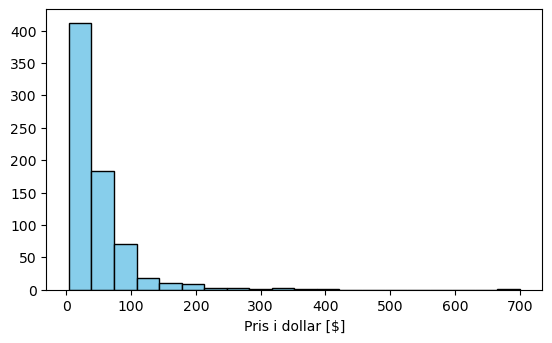

In [562]:
plt.hist(df2['Price'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Pris i dollar [$]')
plt.ylabel('')
plt.gca().set_aspect(1)
plt.show()

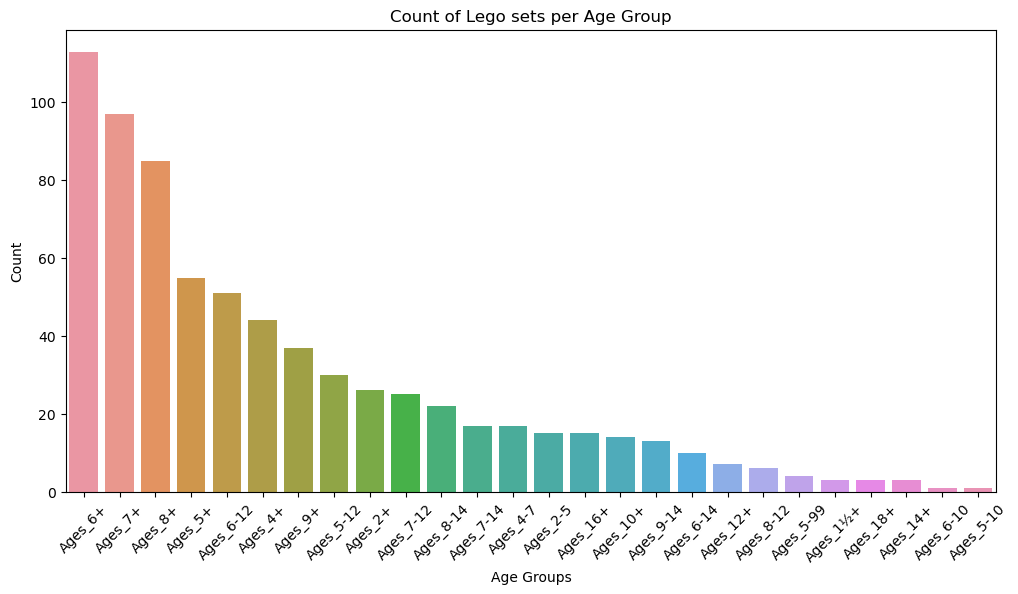

In [563]:
age_order = df2['Ages'].value_counts().index

# Set a larger figure size
plt.figure(figsize=(12, 6))

# Assuming df is your DataFrame with the 'Ages' column
sns.countplot(data=df2, x='Ages', order=age_order)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)  # You can adjust the angle as needed

# Adjust plot aesthetics if needed
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.title('Count of Lego sets per Age Group')

# Show the plot
plt.show()

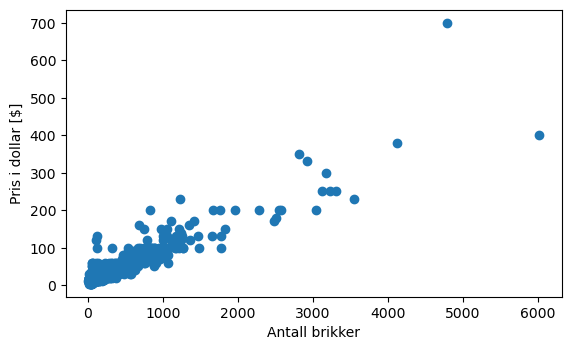

In [564]:
plt.scatter(df2['Pieces'], df2['Price'])
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar [$]')
plt.gca().set_aspect(5)
plt.show()

In [565]:
# hva er det dyreste settet i datasettet mon tro?
print(df2.loc[df2['Price'].idxmax()])

Set_Name         Imperial Star Destroyer
Theme                          Star Wars
Pieces                            4784.0
Price                             699.99
Pages                              444.0
Minifigures                          2.0
Unique_Pieces                      445.0
Ages                            Ages_16+
Age_Category        Teenagers_and_Adults
Name: 825, dtype: object


In [566]:
# og hvilket har flest brikker?
print(df2.loc[df2['Pieces'].idxmax()])

Set_Name              Hogwarts Castle
Theme                    Harry Potter
Pieces                         6020.0
Price                          399.99
Pages                           636.0
Minifigures                      28.0
Unique_Pieces                   624.0
Ages                         Ages_16+
Age_Category     Teenagers_and_Adults
Name: 821, dtype: object


In [567]:
# hvilke tema har de billigste settene?
df2.groupby('Theme')['Price'].mean().sort_values(ascending=True)[:3]

Theme
Minifigures        12.99
Unikitty           18.99
Powerpuff Girls    24.99
Name: Price, dtype: float64

In [568]:
# hvilke tema har flest brikker?

df2.groupby('Age_Category')['Pieces'].mean().sort_values(ascending=False)#[:5]



Age_Category
Teenagers_and_Adults    2635.095238
Older_Children          1000.281690
Children                 357.309038
Young_Children           188.697872
Toddler                   46.159091
Name: Pieces, dtype: float64

In [569]:
df2.groupby('Ages')['Price'].mean().sort_values(ascending=False)

Ages
Ages_16+     243.323333
Ages_14+     223.323333
Ages_18+     183.323333
Ages_12+     175.704286
Ages_9-14     96.528462
Ages_9+       90.935946
Ages_10+      87.490000
Ages_8-12     55.823333
Ages_8-14     53.399091
Ages_8+       52.872353
Ages_7-12     47.190000
Ages_6-12     38.382157
Ages_2-5      37.990000
Ages_2+       35.951538
Ages_7+       32.103402
Ages_1½+      31.656667
Ages_5-99     29.990000
Ages_6+       27.078496
Ages_5+       26.426364
Ages_4+       24.762727
Ages_7-14     24.401765
Ages_4-7      24.107647
Ages_5-12     19.356667
Ages_6-14     15.990000
Ages_6-10      3.990000
Ages_5-10      3.990000
Name: Price, dtype: float64

In [570]:
df2.groupby('Ages')['Unique_Pieces'].mean().sort_values(ascending=False)

Ages
Ages_16+     487.266667
Ages_14+     434.333333
Ages_12+     381.571429
Ages_18+     344.666667
Ages_9+      291.243243
Ages_9-14    268.538462
Ages_10+     250.714286
Ages_5-99    198.000000
Ages_8-12    191.333333
Ages_8+      184.423529
Ages_8-14    181.000000
Ages_7-12    161.760000
Ages_6-12    141.725490
Ages_7+      122.237113
Ages_7-14    113.882353
Ages_6+      106.008850
Ages_5+       94.054545
Ages_5-12     87.800000
Ages_4-7      85.588235
Ages_4+       73.181818
Ages_6-14     68.500000
Ages_1½+      50.333333
Ages_2+       29.192308
Ages_2-5      28.733333
Ages_5-10     28.000000
Ages_6-10     23.000000
Name: Unique_Pieces, dtype: float64

In [571]:
df2.groupby('Ages')['Minifigures'].mean().sort_values(ascending=False)

Ages
Ages_16+     7.533333
Ages_14+     7.333333
Ages_12+     6.142857
Ages_9-14    5.692308
Ages_9+      5.162162
Ages_8-14    3.909091
Ages_8+      3.847059
Ages_18+     3.666667
Ages_10+     3.285714
Ages_5-12    3.166667
Ages_5+      2.890909
Ages_6-12    2.862745
Ages_7+      2.855670
Ages_7-12    2.840000
Ages_8-12    2.833333
Ages_7-14    2.647059
Ages_6+      2.628319
Ages_6-14    2.500000
Ages_4+      2.409091
Ages_2+      2.384615
Ages_4-7     2.294118
Ages_5-99    2.000000
Ages_2-5     1.933333
Ages_1½+     1.666667
Ages_6-10    1.000000
Ages_5-10    1.000000
Name: Minifigures, dtype: float64

In [572]:
df2.groupby('Ages')['Pages'].mean().sort_values(ascending=False)

Ages
Ages_16+     341.933333
Ages_14+     264.000000
Ages_12+     240.142857
Ages_18+     238.666667
Ages_9+      203.243243
Ages_10+     185.142857
Ages_8-12    184.666667
Ages_9-14    176.307692
Ages_8+      127.647059
Ages_7-12    123.040000
Ages_8-14    106.363636
Ages_6-12    103.960784
Ages_7+       89.144330
Ages_7-14     82.352941
Ages_5+       78.581818
Ages_6+       76.840708
Ages_4-7      66.117647
Ages_4+       64.863636
Ages_5-99     60.000000
Ages_5-12     55.800000
Ages_6-14     39.200000
Ages_2-5      24.600000
Ages_2+       22.500000
Ages_1½+      11.333333
Ages_6-10      3.000000
Ages_5-10      3.000000
Name: Pages, dtype: float64

/Users/anderslund/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


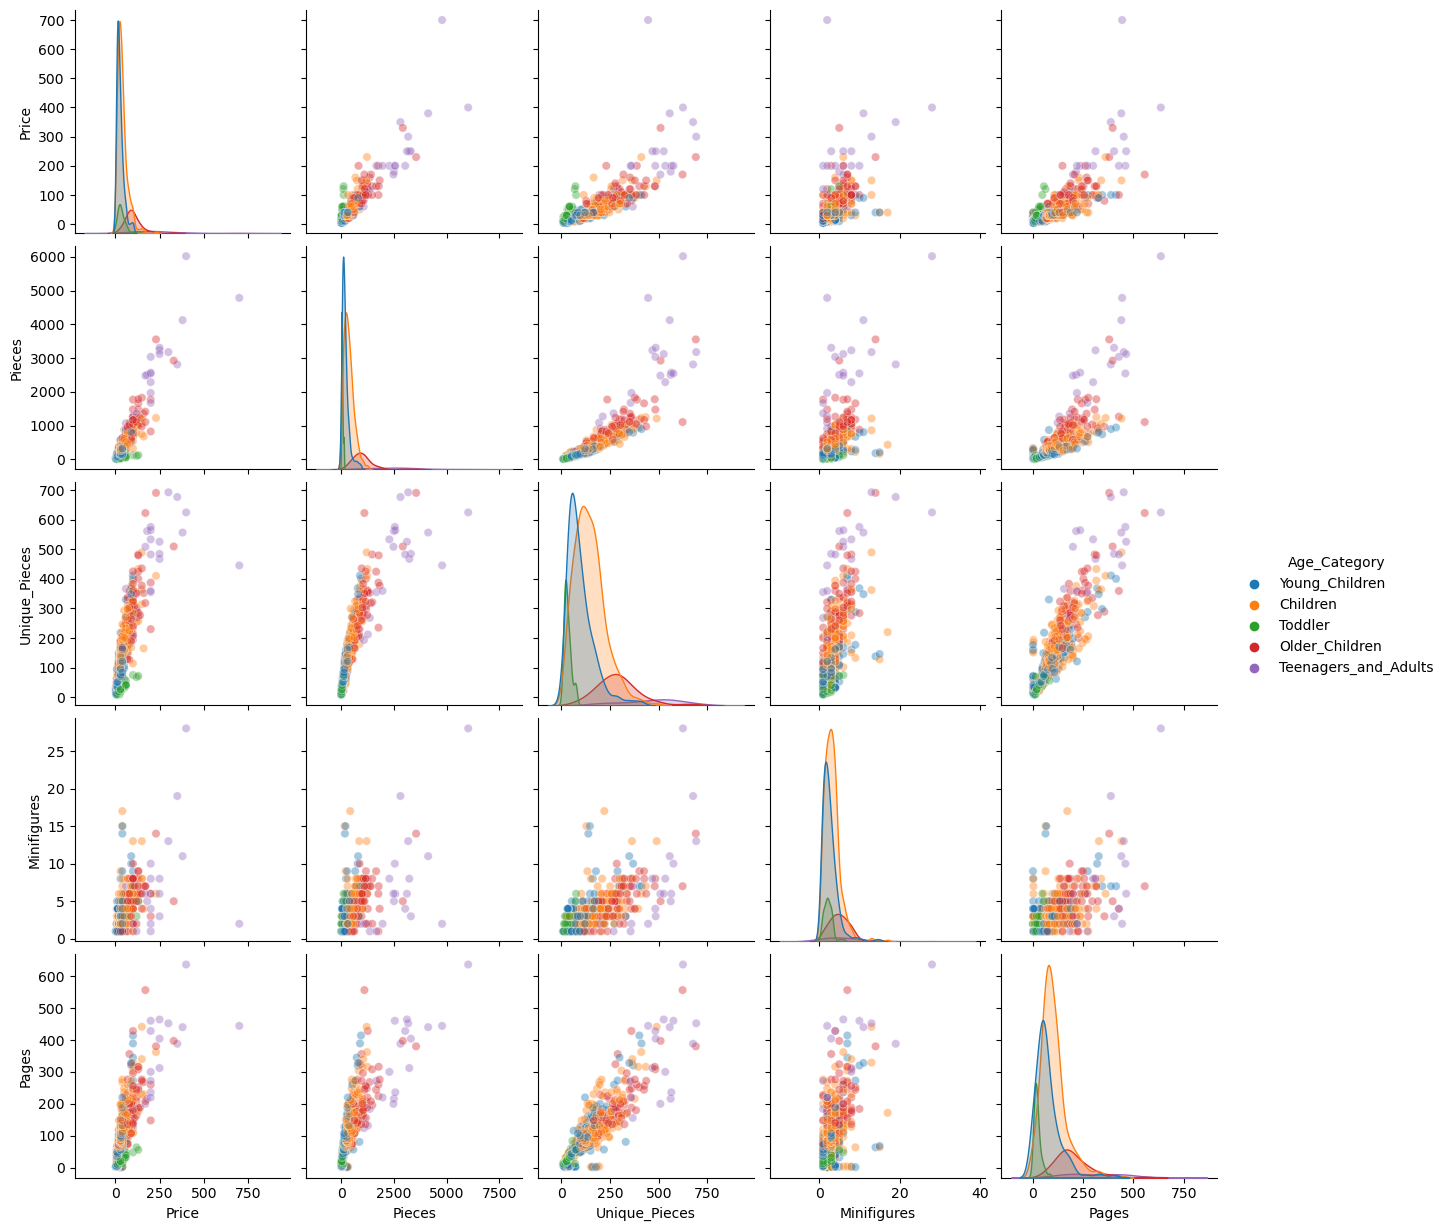

In [573]:
sns.pairplot(df2, vars = ['Price', 'Pieces', 'Unique_Pieces', 'Minifigures', 'Pages'],
             hue = 'Age_Category', 
             diag_kind = 'kde',
             plot_kws = dict(alpha = 0.4))
plt.show()

In [574]:
# enkel lineær regresjon
formel = 'Price ~ Pieces'

modell = smf.ols(formel, data = df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     3802.
Date:                Sun, 12 Nov 2023   Prob (F-statistic):          9.01e-288
Time:                        16:38:56   Log-Likelihood:                -3194.2
No. Observations:                 714   AIC:                             6392.
Df Residuals:                     712   BIC:                             6401.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2338      0.988     10.363      0.000       8.295      12.173
Pieces         0.0873      0.001     61.664      0.000       0.085       0.090
==============================================================================
Omnibus:                      659.458   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61214.067
Skew:                           3.717   Prob(JB):                         0.00
Kurtosis:                      47.748   Cond. No.                         866.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

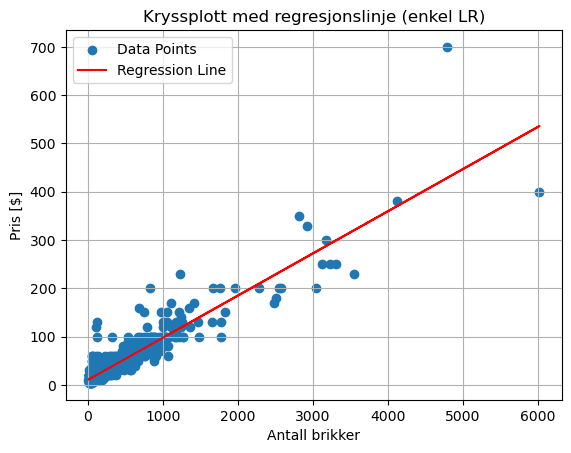

In [575]:
slope = resultat.params['Pieces']
intercept = resultat.params['Intercept']

regression_x = np.array(df2['Pieces'])

regression_y = slope * regression_x + intercept

plt.scatter(df2['Pieces'], df2['Price'], label='Data Points')
plt.plot(regression_x, regression_y, color='red', label='Regression Line')
plt.xlabel('Antall brikker')
plt.ylabel('Pris [$]')
plt.title('Kryssplott med regresjonslinje (enkel LR)')
plt.legend()
plt.grid()
plt.show()

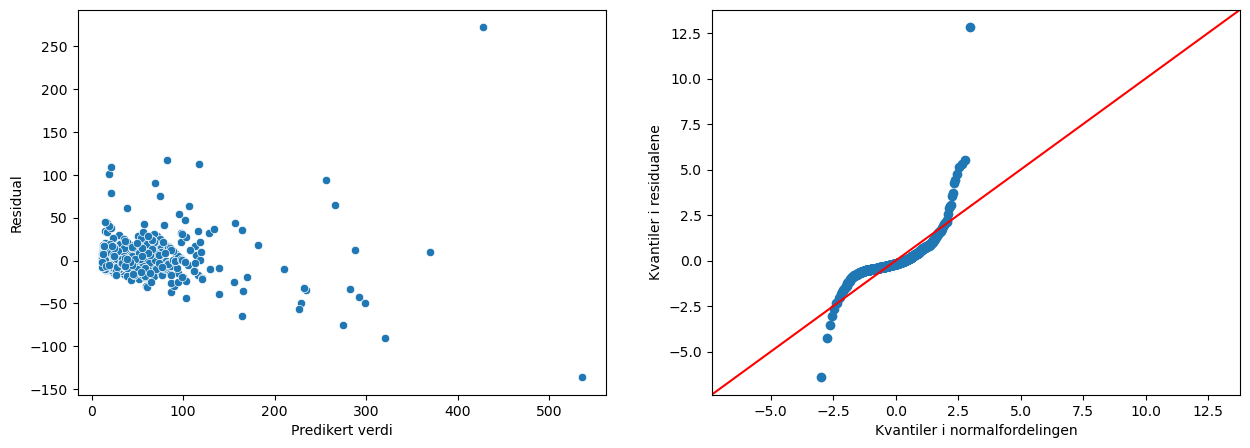

In [576]:
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = resultat.fittedvalues, y = resultat.resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

sm.qqplot(resultat.resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()

/Users/anderslund/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


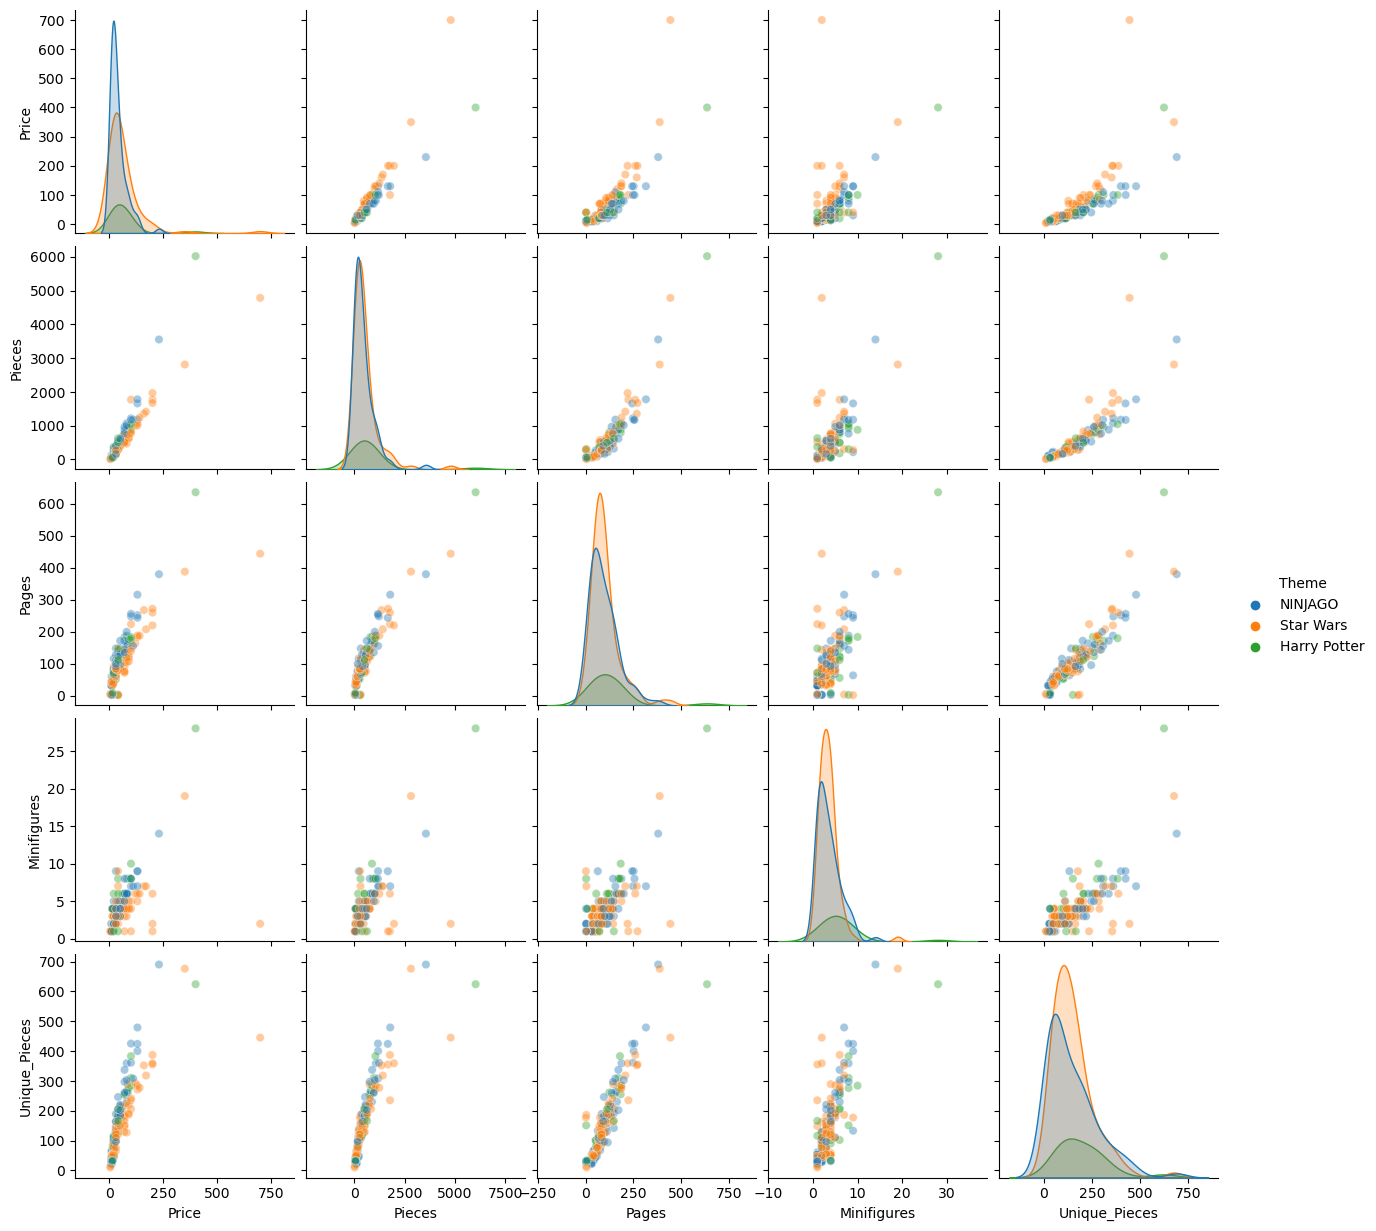

In [577]:
mythemes = ['Star Wars', 'NINJAGO', 'Harry Potter']
subset_df = df2[df2['Theme'].isin(mythemes)]
sns.pairplot(subset_df, vars = ['Price', 'Pieces', 'Pages', 'Minifigures', 'Unique_Pieces'],
             hue = 'Theme', 
             diag_kind = 'kde',
             plot_kws = dict(alpha = 0.4))
plt.show()

In [578]:
# enkel lineær regresjon, tar ikke hensyn til tema
res_sub = smf.ols('Price ~ Pieces' , data = subset_df).fit()

In [579]:
# enkel LR for hvert tema hver for seg
resultater = []
for i, theme in enumerate(mythemes):
    modell3 = smf.ols('Price ~ Pieces' , data = subset_df[subset_df['Theme'].isin([theme])])
    resultater.append(modell3.fit())

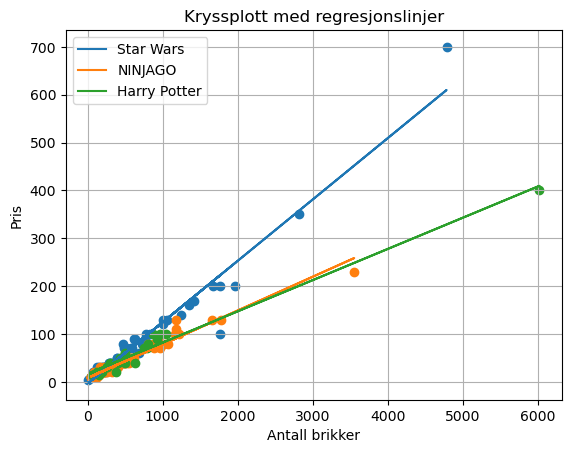

In [580]:
# plott av dataene og regresjonslinjene
for i, theme in enumerate(mythemes):
    slope = resultater[i].params['Pieces']
    intercept = resultater[i].params['Intercept']

    regression_x = np.array(subset_df[subset_df['Theme'].isin([theme])]['Pieces'])
    regression_y = slope * regression_x + intercept

    # Plot scatter plot and regression line
    plt.scatter(subset_df[subset_df['Theme'].isin([theme])]['Pieces'], subset_df[subset_df['Theme'].isin([theme])]['Price'], color=plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=theme)
    
plt.xlabel('Antall brikker')
plt.ylabel('Pris')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

In [581]:
print(df2['Age_Category'].unique())

['Young_Children' 'Children' 'Toddler' 'Older_Children'
 'Teenagers_and_Adults']


In [583]:
# Konverter Age_Category til dummy-variabler
df3 = df2.copy()
df3['Age_Category'].fillna('missing', inplace=True)
df3 = pd.get_dummies(df3, columns=['Age_Category'], drop_first=True)

# Velg forklaringsvariabler og responsvariabel
X = df3.drop(['Price', 'Set_Name', 'Theme', 'Unique_Pieces', 'Pages', 'Minifigures', 'Ages', 'Pieces'], axis=1)
y = df3['Price']

# Print data types of X for verification
print(X.dtypes)
print(y.dtypes)
print(X.value_counts())

columns_to_fill = ['Age_Category_Older_Children', 'Age_Category_Teenagers_and_Adults', 'Age_Category_Toddler', 'Age_Category_Young_Children']

# Fill missing values with 0 for the specified columns
df3[columns_to_fill] = df3[columns_to_fill].fillna(0)

df3[columns_to_fill] = df3[columns_to_fill].replace('', False)
df3[columns_to_fill] = df3[columns_to_fill].fillna(False)

for column in columns_to_fill:
    df[df[column] != True]
    if (df3[column].any()):
        print(column, df3[column].unique())

# Legg til en konstant til X (nødvendig for statsmodels)
X = sm.add_constant(X)

# Opprett og tilpasse modellen
model = sm.OLS(y, X).fit()

# Print ut en oppsummering av modellen
print(model.summary())


Age_Category_Older_Children          bool
Age_Category_Teenagers_and_Adults    bool
Age_Category_Toddler                 bool
Age_Category_Young_Children          bool
dtype: object
float64
Age_Category_Older_Children  Age_Category_Teenagers_and_Adults  Age_Category_Toddler  Age_Category_Young_Children
False                        False                              False                 False                          343
                                                                                      True                           235
True                         False                              False                 False                           71
False                        False                              True                  False                           44
                             True                               False                 False                           21
Name: count, dtype: int64


KeyError: 'Age_Category_Older_Children'

In [ ]:
# multippel lineær regresjon
modell3_mlr = smf.ols('Price ~ Pieces + Theme' , data = subset_df)
modell3_mlr.fit().summary()

In [ ]:
# multippel lineær regresjon med en annen referansekategori
modell3_mlr_alt = smf.ols('Price ~ Pieces + C(Theme, Treatment("Star Wars"))' , data = subset_df)
modell3_mlr_alt.fit().summary()

In [ ]:
# plott
intercept = [modell3_mlr.fit().params['Theme[T.Star Wars]'], modell3_mlr.fit().params['Theme[T.NINJAGO]'], 0] + modell3_mlr.fit().params['Intercept']
slope = modell3_mlr.fit().params['Pieces']

for i, theme in enumerate(mythemes):

    regression_x = np.array(subset_df[subset_df['Theme'].isin([theme])]['Pieces'])
    regression_y = slope * regression_x + intercept[i]

    # Plot scatter plot and regression line
    plt.scatter(subset_df[subset_df['Theme'].isin([theme])]['Pieces'], subset_df[subset_df['Theme'].isin([theme])]['Price'], color = plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=theme)
    
# uten tema som forklaringsvariabel:
regression_x = np.array(subset_df['Pieces'])
regression_y = res_sub.params['Pieces'] * regression_x + res_sub.params['Intercept']
plt.plot(regression_x, regression_y, color='black', label = 'No theme')
    
plt.xlabel('Antall brikker')
plt.ylabel('Pris')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# med interaksjonsledd mellom antall brikker og tema
modell3_mlri = smf.ols('Price ~ Pieces*Theme' , data = subset_df)
modell3_mlri.fit().summary()

In [ ]:
# plott
intercept = [modell3_mlri.fit().params['Theme[T.Star Wars]'], modell3_mlri.fit().params['Theme[T.NINJAGO]'], 0] + modell3_mlri.fit().params['Intercept']
slope = [modell3_mlri.fit().params['Pieces:Theme[T.Star Wars]'], modell3_mlri.fit().params['Pieces:Theme[T.NINJAGO]'], 0] + modell3_mlri.fit().params['Pieces']

for i, theme in enumerate(mythemes):

    regression_x = np.array(subset_df[subset_df['Theme'].isin([theme])]['Pieces'])
    regression_y = slope[i] * regression_x + intercept[i]

    # Plot scatter plot and regression line
    plt.scatter(subset_df[subset_df['Theme'].isin([theme])]['Pieces'], subset_df[subset_df['Theme'].isin([theme])]['Price'], color=plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=theme)
    
# uten tema som forklaringsvariabel:
regression_x = np.array(subset_df['Pieces'])
regression_y = res_sub.params['Pieces'] * regression_x + res_sub.params['Intercept']
plt.plot(regression_x, regression_y, color='black', label='Theme unaccounted for')
    
plt.xlabel('Antall brikker')
plt.ylabel('Pris [$]')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Kode for å lagre plot som (.png)
## fjern 'plt.show()' og erstatt med:
# plt.savefig('my_plot.png')

In [ ]:
# Steg 5: Evaluere om modellen passer til dataene
# Plotte predikert verdi mot residual
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = modell3_mlri.fit().fittedvalues, y = modell3_mlri.fit().resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

# Lage kvantil-kvantil-plott for residualene
sm.qqplot(modell3_mlri.fit().resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()

In [ ]:
# Gruppere temaer i nye grupper:
# (Harry Potter, NINJAGO og Star Wars havner i én gruppe, City og Friends i en annen, og alle andre i en tredje)
df2['cat'] = np.where(df2['Theme'].isin(['Harry Potter', 'NINJAGO', 'Star Wars']), 'Cat1', 
                      np.where(df2['Theme'].isin(['City', 'Friends']), 'Cat2', 'Cat3'))
df2.groupby(['cat']).size().reset_index(name = 'Count')

In [ ]:
df2.groupby(['cat', 'Theme']).size().reset_index(name = 'Count')